In [1]:
# License: BSD
# Author: Sasank Chilamkurthy
# https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html
# https://pytorch.org/docs/stable/torchvision/models.html

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

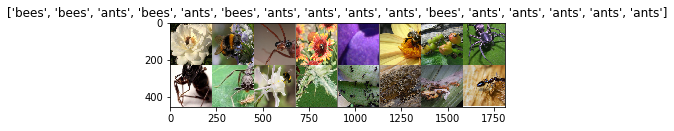

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## model setting

In [6]:
#model_ft = models.resnet18(pretrained=True)
model_ft=models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6895 Acc: 0.5656
val Loss: 0.3337 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.3722 Acc: 0.8525
val Loss: 0.2154 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2865 Acc: 0.8730
val Loss: 0.2332 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.2335 Acc: 0.8975
val Loss: 0.1780 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.1629 Acc: 0.9344
val Loss: 0.1689 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.1487 Acc: 0.9385
val Loss: 0.1623 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1490 Acc: 0.9549
val Loss: 0.2045 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.1525 Acc: 0.9180
val Loss: 0.2157 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.1686 Acc: 0.9385
val Loss: 0.1768 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.1127 Acc: 0.9713
val Loss: 0.1694 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1266 Acc: 0.9549
val Loss: 0.1667 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.1077 Acc: 0.9672
val Loss: 0.1671 Acc: 0.9477

Ep

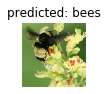

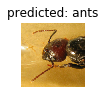

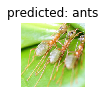

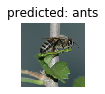

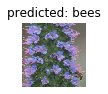

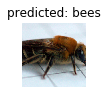

In [8]:
visualize_model(model_ft)

## model setting

In [9]:
#model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7030 Acc: 0.5205
val Loss: 0.4571 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.4502 Acc: 0.7951
val Loss: 0.2530 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3156 Acc: 0.8811
val Loss: 0.2313 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3268 Acc: 0.8566
val Loss: 0.1850 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2727 Acc: 0.8975
val Loss: 0.1798 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.2418 Acc: 0.8893
val Loss: 0.1875 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2171 Acc: 0.9221
val Loss: 0.1656 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2095 Acc: 0.9262
val Loss: 0.1724 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2074 Acc: 0.9098
val Loss: 0.1657 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2062 Acc: 0.9098
val Loss: 0.1619 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2359 Acc: 0.9098
val Loss: 0.1652 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2265 Acc: 0.9180
val Loss: 0.1624 Acc: 0.9477

Ep

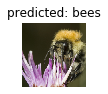

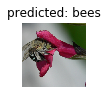

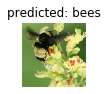

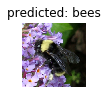

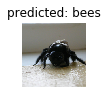

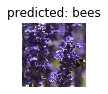

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 저장부

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

In [349]:
torch.save({
            'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'loss': criterion
            }, 'd:/test.pt')

## 봉인해제

In [350]:
for param in model_conv.parameters():
    param.requires_grad = True

In [351]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1741 Acc: 0.9303
val Loss: 0.1766 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.2333 Acc: 0.9016
val Loss: 0.1669 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1781 Acc: 0.9467
val Loss: 0.1689 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.2402 Acc: 0.9098
val Loss: 0.1741 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2132 Acc: 0.9057
val Loss: 0.1706 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.1935 Acc: 0.9303
val Loss: 0.1782 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.2126 Acc: 0.9262
val Loss: 0.1677 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.2598 Acc: 0.8852
val Loss: 0.1715 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2157 Acc: 0.9098
val Loss: 0.1714 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2170 Acc: 0.9139
val Loss: 0.1694 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2147 Acc: 0.9016
val Loss: 0.1733 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.1922 Acc: 0.9385
val Loss: 0.1742 Acc: 0.9542

Ep

## Precision ( 정밀도를 위한 추가 과정 )

In [13]:
def result_out(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # added

    temp = {}
    temp['inputs'] = []
    temp['labels'] = []
    temp['outputs'] = []
    temp['preds'] = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)         

            outputs = model(inputs)
            
            temp['inputs'].append(inputs)
            temp['labels'].append(labels)
            temp['outputs'].append(outputs)
            
            _, preds = torch.max(outputs, 1)
            temp['preds'].append(preds)
        model.train(mode=was_training)

    return temp

In [14]:
result_fin = result_out(model_conv)

<Figure size 432x288 with 0 Axes>

In [15]:
result_fin.keys()

dict_keys(['inputs', 'labels', 'outputs', 'preds'])

In [16]:
result_fin['outputs'][9]

tensor([[ 1.3795,  0.4465],
        [-1.3009,  3.1257],
        [-0.3164,  2.1636],
        [-1.6373,  1.7174],
        [-2.5337,  3.2577],
        [ 0.7086,  1.5450],
        [ 1.6159, -0.9331],
        [ 1.5388, -1.0627],
        [-0.7865,  2.4456]], device='cuda:0')

In [17]:
# _, preds = torch.max(result_fin['outputs'][0], 1)

In [19]:
result_fin['preds']

[tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0'),
 tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0'),
 tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0'),
 tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0'),
 tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0'),
 tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0'),
 tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0'),
 tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0'),
 tensor([0, 1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')]

In [20]:
labels = []
for i in range(len(result_fin['labels'])):
    for j in range(len(result_fin['labels'][i])):
        labels.append(int(result_fin['labels'][i][j]))

In [21]:
outputs = []
for i in range(len(result_fin['outputs'])):
    for j in range(len(result_fin['outputs'][i])):
        outputs.append(list(result_fin['outputs'][i][j]))

In [22]:
preds = []
for i in range(len(result_fin['preds'])):
    for j in range(len(result_fin['preds'][i])):
        preds.append(int(result_fin['preds'][i][j]))

In [23]:
len(preds)

153

In [24]:
# tensor 형태에도 조건식 정상 작동하는지 확인
outputs[0][0] > outputs[0][1]

tensor(False, device='cuda:0')

In [25]:
# tensor 형태에도 조건식 정상 작동하는지 확인 2
if outputs[0][0] > outputs[0][1] : 
    print('true')
print('--------')
if outputs[0][0] < outputs[0][1] : 
    print('true')
else :
    print('false')

--------
true


In [26]:
import pandas as pd

In [27]:
df_outputs = pd.DataFrame(outputs)

In [28]:
df_outputs # 값 flot 으로 전환시킬 줄 알았는데, 문자열로 치환됨.. 대책이 필요

0                                 1
0     tensor(0.3901, device='cuda:0')   tensor(0.5440, device='cuda:0')
1     tensor(3.6166, device='cuda:0')  tensor(-1.9786, device='cuda:0')
2    tensor(-0.9370, device='cuda:0')   tensor(2.0864, device='cuda:0')
3    tensor(-0.8112, device='cuda:0')   tensor(0.9268, device='cuda:0')
4     tensor(2.7397, device='cuda:0')  tensor(-1.4133, device='cuda:0')
..                                ...                               ...
148  tensor(-2.5337, device='cuda:0')   tensor(3.2577, device='cuda:0')
149   tensor(0.7086, device='cuda:0')   tensor(1.5450, device='cuda:0')
150   tensor(1.6159, device='cuda:0')  tensor(-0.9331, device='cuda:0')
151   tensor(1.5388, device='cuda:0')  tensor(-1.0627, device='cuda:0')
152  tensor(-0.7865, device='cuda:0')   tensor(2.4456, device='cuda:0')

[153 rows x 2 columns]

In [29]:
# 각각 float으로 바꿔서 넣음
outputs = []
for i in range(len(result_fin['outputs'])):
    for j in range(len(result_fin['outputs'][i])):
        #outputs.append(list(result_fin['outputs'][i][j]))
        outputs.append(
            [ float(result_fin['outputs'][i][j][0]) , float(result_fin['outputs'][i][j][1]) ]
        )

In [30]:
outputs[:5]

[[0.3901445269584656, 0.5439944863319397],
 [3.6166117191314697, -1.9785807132720947],
 [-0.9370300769805908, 2.0863828659057617],
 [-0.8111906051635742, 0.9267679452896118],
 [2.7396905422210693, -1.4133086204528809]]

In [31]:
# 보기 편하게 dataframe으로 바꿈
df_outputs = pd.DataFrame(outputs)
df_outputs

0         1
0    0.390145  0.543994
1    3.616612 -1.978581
2   -0.937030  2.086383
3   -0.811191  0.926768
4    2.739691 -1.413309
..        ...       ...
148 -2.533702  3.257707
149  0.708555  1.545016
150  1.615887 -0.933054
151  1.538845 -1.062721
152 -0.786508  2.445620

[153 rows x 2 columns]

## 확률 비교전 정규화 (최소 최대치를 고려한 상대거리로 전환)

In [33]:
# 최대값
max_for_n = max(max(df_outputs[0]),max(df_outputs[1]))
max_for_n

4.535218238830566

In [34]:
# 최솟값
min_for_n = min(min(df_outputs[0]),min(df_outputs[1]))
min_for_n

-3.406691551208496

In [35]:
df_outputs[0] # 그냥 확인용

0      0.390145
1      3.616612
2     -0.937030
3     -0.811191
4      2.739691
         ...   
148   -2.533702
149    0.708555
150    1.615887
151    1.538845
152   -0.786508
Name: 0, Length: 153, dtype: float64

In [36]:
# 정규화 ( Normalization 코드 )

df_output_mutate = [[],[]]
df_output_mutate[0] = []
df_output_mutate[1] = []

for (x,y) in zip(df_outputs[0],df_outputs[1]) :
    temp0 = (x-min_for_n)/(max_for_n-min_for_n)
    temp1 = (y-min_for_n)/(max_for_n-min_for_n)
    df_output_mutate[0].append(temp0)
    df_output_mutate[1].append(temp1)
    
df_output_mutate = pd.DataFrame(df_output_mutate)
df_output_mutate = df_output_mutate.T
df_output_mutate

0         1
0    0.478076  0.497448
1    0.884334  0.179820
2    0.310966  0.691657
3    0.326811  0.545645
4    0.773917  0.250995
..        ...       ...
148  0.109922  0.839143
149  0.518168  0.623491
150  0.632414  0.311466
151  0.622714  0.295139
152  0.329919  0.736890

[153 rows x 2 columns]

In [271]:
import matplotlib.pyplot as plt
#import seaborn as sns

In [38]:
output_ex = list(df_output_mutate[0])+(list(df_output_mutate[1]))
len(output_ex)

306

(array([ 6., 23., 51., 49., 25., 21., 55., 47., 25.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

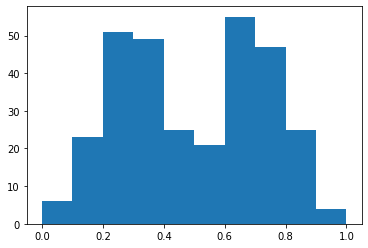

In [39]:
plt.hist(output_ex)

In [40]:
max(output_ex)

1.0

In [41]:
min(output_ex)

0.0

## 0 이 음성 / 1이 양성이라고 가정할 때

In [42]:
# 정답
labels[:10]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [43]:
# 예측을 위한 정규화 된 값
df_output_mutate[:][:10]

0         1
0  0.478076  0.497448
1  0.884334  0.179820
2  0.310966  0.691657
3  0.326811  0.545645
4  0.773917  0.250995
5  0.213326  0.754180
6  0.339871  0.587404
7  0.320735  0.665100
8  0.741151  0.241910
9  0.445958  0.588909

In [142]:
df_output_mutate[0][1]+df_output_mutate[1][1]
# 하... 합이 1이 아니라 정확한 확률이라 하기 힘듦. 비율을 계산해서 확률로 전환해야함

1.0641538788159415

In [143]:
# a / a+b 공식으로 확률로 전환
output_for_pred = []
for i in range(len(df_output_mutate)):
    temp = df_output_mutate[1][i]/(df_output_mutate[0][i]+df_output_mutate[1][i])
    output_for_pred.append(temp)
output_for_pred[:10]

[0.5099289783930759,
 0.16897892111781265,
 0.6898476217309739,
 0.6254126477459965,
 0.24489440725043046,
 0.7795091390986651,
 0.6334732904721813,
 0.6746563009801348,
 0.24607845592236616,
 0.5690672681616921]

In [144]:
# 정답
labels[:10]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [145]:
# 5% 이상일 때
predicted_th5 = [ 1 if x > 0.05 else 0 for x in output_for_pred]
predicted_th5[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [146]:
# 10% 이상일 때
predicted_th10 = [ 1 if x > 0.1 else 0 for x in output_for_pred]
predicted_th10[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [147]:
# 30% 이상일 때
predicted_th30 = [ 1 if x > 0.3 else 0 for x in output_for_pred]
predicted_th30[:10]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [148]:
# 50% 이상일 때
predicted_th50 = [ 1 if x > 0.5 else 0 for x in output_for_pred]
predicted_th50[:10]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [149]:
# 80% 이상일 때
predicted_th80 = [ 1 if x > 0.8 else 0 for x in output_for_pred]
predicted_th80[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [150]:
# 90% 이상일 때
predicted_th90 = [ 1 if x > 0.9 else 0 for x in output_for_pred]
predicted_th90[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [251]:
def cal_precision(threashold,labels, preds):
    
    TP = 0
    FP = 0
    same = 0
    
    if len(labels) == len(preds):
        for i in range(len(labels)):
            if (labels[i] == 1) and  (preds[i] == 1): # 실제 양성 / 예측 양성  = True Positive
                TP = TP +1
            elif (labels[i] == 0) and (preds[i] == 1): # 실제 음성 / 예측 양성  = False Positive
                FP = FP +1
                
            if labels[i] == preds[i]:
                same = same +1

    else:
        print("error")
        return 0
    try:
        PRE = TP/(TP+FP)
        return [threashold,TP,FP,PRE,same,same/len(labels)]
    except:
        #print("TP : ", "TP", " // FP : ", FP)
        return [threashold,TP,FP,0,same,same/len(labels)]
    #return TP/(TP+FP)
    #return [TP,FP,PRE,same,same/len(labels)]

In [327]:
def cal_precision_full(labels, output_for_pred):
    temp_res = []
    for i in list(range(1,100000)):
        temp_pred = [ 1 if x > i*0.00001 else 0 for x in output_for_pred]
        temp_res.append(cal_precision(i*0.001,labels,temp_pred))
    return temp_res

In [366]:
df_final = pd.DataFrame(cal_precision_full(labels, output_for_pred))
df_final.columns = ["Threashold","TP","FP","Precision","Correct","Accuracy"]
df_final

Threashold  TP  FP  Precision  Correct  Accuracy
0           0.001  83  70   0.542484       83  0.542484
1           0.002  83  70   0.542484       83  0.542484
2           0.003  83  70   0.542484       83  0.542484
3           0.004  83  70   0.542484       83  0.542484
4           0.005  83  70   0.542484       83  0.542484
...           ...  ..  ..        ...      ...       ...
99994      99.995   1   0   1.000000       71  0.464052
99995      99.996   1   0   1.000000       71  0.464052
99996      99.997   1   0   1.000000       71  0.464052
99997      99.998   1   0   1.000000       71  0.464052
99998      99.999   1   0   1.000000       71  0.464052

[99999 rows x 6 columns]

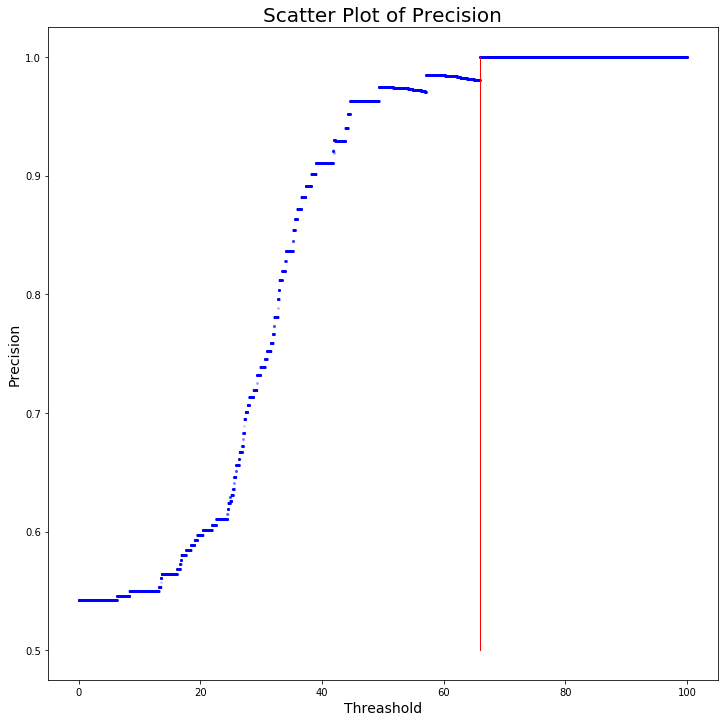

In [367]:
f1 = plt.figure(figsize=(12,12))

plt.plot('Threashold','Precision', data=df_final, 
         linestyle='none', marker='o', markersize=2,color='blue',alpha=0.01
        )
plt.plot([66,66],[0.5,1], color='red', lw=1, linestyle='solid')
plt.title('Scatter Plot of Precision', fontsize=20)

plt.xlabel('Threashold', fontsize=14)

plt.ylabel('Precision', fontsize=14)

plt.show()

In [368]:
df_final[['Threashold','Precision']][65930:65940]

Threashold  Precision
65930      65.931   0.980392
65931      65.932   0.980392
65932      65.933   0.980392
65933      65.934   0.980392
65934      65.935   1.000000
65935      65.936   1.000000
65936      65.937   1.000000
65937      65.938   1.000000
65938      65.939   1.000000
65939      65.940   1.000000

In [369]:
df_final[:][65930:65940]

Threashold  TP  FP  Precision  Correct  Accuracy
65930      65.931  50   1   0.980392      119  0.777778
65931      65.932  50   1   0.980392      119  0.777778
65932      65.933  50   1   0.980392      119  0.777778
65933      65.934  50   1   0.980392      119  0.777778
65934      65.935  50   0   1.000000      120  0.784314
65935      65.936  50   0   1.000000      120  0.784314
65936      65.937  50   0   1.000000      120  0.784314
65937      65.938  50   0   1.000000      120  0.784314
65938      65.939  50   0   1.000000      120  0.784314
65939      65.940  50   0   1.000000      120  0.784314

In [370]:
df_final[['Threashold','Precision']][60000:67000:1000]

Threashold  Precision
60000      60.001   0.984848
61000      61.001   0.984127
62000      62.001   0.984127
63000      63.001   0.982759
64000      64.001   0.981818
65000      65.001   0.981132
66000      66.001   1.000000

## 확률 합계를 1로 맞춰주지 않은 경우

In [371]:
df_final2 = pd.DataFrame(cal_precision_full(labels, df_output_mutate[1]))
df_final2.columns = ["Threashold","TP","FP","Precision","Correct","Accuracy"]
df_final2

Threashold  TP  FP  Precision  Correct  Accuracy
0           0.001  83  70   0.542484       83  0.542484
1           0.002  83  70   0.542484       83  0.542484
2           0.003  83  70   0.542484       83  0.542484
3           0.004  83  70   0.542484       83  0.542484
4           0.005  83  70   0.542484       83  0.542484
...           ...  ..  ..        ...      ...       ...
99994      99.995   1   0   1.000000       71  0.464052
99995      99.996   1   0   1.000000       71  0.464052
99996      99.997   1   0   1.000000       71  0.464052
99997      99.998   1   0   1.000000       71  0.464052
99998      99.999   1   0   1.000000       71  0.464052

[99999 rows x 6 columns]

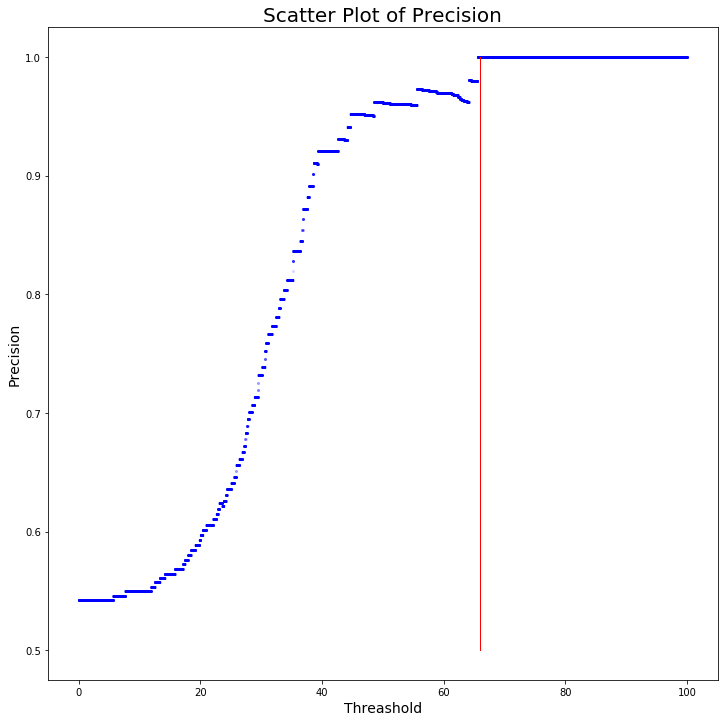

In [372]:
f1 = plt.figure(figsize=(12,12))

plt.plot('Threashold','Precision', data=df_final2, 
         linestyle='none', marker='o', markersize=2,color='blue',alpha=0.01
        )
plt.plot([66,66],[0.5,1], color='red', lw=1, linestyle='solid')
plt.title('Scatter Plot of Precision', fontsize=20)

plt.xlabel('Threashold', fontsize=14)

plt.ylabel('Precision', fontsize=14)

plt.show()

In [373]:
df_final2[['Threashold','Precision']][60000:67000:1000]

Threashold  Precision
60000      60.001   0.970149
61000      61.001   0.969697
62000      62.001   0.967742
63000      63.001   0.963636
64000      64.001   0.962264
65000      65.001   0.979592
66000      66.001   1.000000

In [382]:
df_final2[df_final2['Precision']>df_final['Precision']]

Threashold  TP  FP  Precision  Correct  Accuracy
5696        5.697  83  69   0.546053       84   0.54902
5697        5.698  83  69   0.546053       84   0.54902
5698        5.699  83  69   0.546053       84   0.54902
5699        5.700  83  69   0.546053       84   0.54902
5700        5.701  83  69   0.546053       84   0.54902
...           ...  ..  ..        ...      ...       ...
65929      65.930  46   0   1.000000      116   0.75817
65930      65.931  46   0   1.000000      116   0.75817
65931      65.932  46   0   1.000000      116   0.75817
65932      65.933  46   0   1.000000      116   0.75817
65933      65.934  46   0   1.000000      116   0.75817

[15010 rows x 6 columns]

In [384]:
df_final2[df_final2['Precision']==df_final['Precision']]

Threashold  TP  FP  Precision  Correct  Accuracy
0           0.001  83  70   0.542484       83  0.542484
1           0.002  83  70   0.542484       83  0.542484
2           0.003  83  70   0.542484       83  0.542484
3           0.004  83  70   0.542484       83  0.542484
4           0.005  83  70   0.542484       83  0.542484
...           ...  ..  ..        ...      ...       ...
99994      99.995   1   0   1.000000       71  0.464052
99995      99.996   1   0   1.000000       71  0.464052
99996      99.997   1   0   1.000000       71  0.464052
99997      99.998   1   0   1.000000       71  0.464052
99998      99.999   1   0   1.000000       71  0.464052

[50802 rows x 6 columns]

In [385]:
df_final2[df_final2['Precision']<df_final['Precision']]

Threashold  TP  FP  Precision  Correct  Accuracy
13630      13.631  83  65   0.560811       88  0.575163
13631      13.632  83  65   0.560811       88  0.575163
13632      13.633  83  65   0.560811       88  0.575163
13633      13.634  83  65   0.560811       88  0.575163
13634      13.635  83  65   0.560811       88  0.575163
...           ...  ..  ..        ...      ...       ...
65537      65.538  48   1   0.979592      117  0.764706
65538      65.539  48   1   0.979592      117  0.764706
65539      65.540  48   1   0.979592      117  0.764706
65540      65.541  48   1   0.979592      117  0.764706
65541      65.542  48   1   0.979592      117  0.764706

[34187 rows x 6 columns]

(array([ 6., 18., 27., 15., 11., 14., 35., 15.,  9.,  3.]),
 array([0.05696371, 0.15126734, 0.24557097, 0.3398746 , 0.43417823,
        0.52848186, 0.62278549, 0.71708911, 0.81139274, 0.90569637,
        1.        ]),
 <a list of 10 Patch objects>)

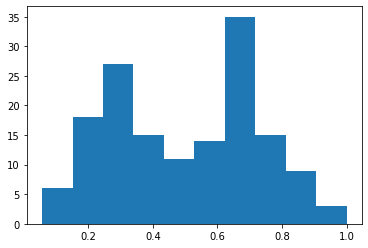

In [386]:
plt.hist(df_output_mutate[1])

(array([1284., 1933., 2508., 1741., 1507., 2828., 1304.,    0., 1513.,
         392.]),
 array([ 5.697 , 11.7207, 17.7444, 23.7681, 29.7918, 35.8155, 41.8392,
        47.8629, 53.8866, 59.9103, 65.934 ]),
 <a list of 10 Patch objects>)

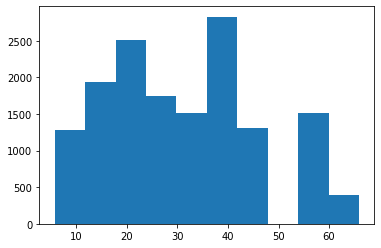

In [388]:
plt.hist(df_final2[df_final2['Precision']>df_final['Precision']]['Threashold'])

(array([ 8716.,  4218.,  2254.,  1469.,    80.,     0.,  4065., 10000.,
        10000., 10000.]),
 array([1.00000e-03, 1.00008e+01, 2.00006e+01, 3.00004e+01, 4.00002e+01,
        5.00000e+01, 5.99998e+01, 6.99996e+01, 7.99994e+01, 8.99992e+01,
        9.99990e+01]),
 <a list of 10 Patch objects>)

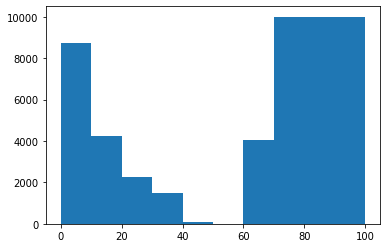

In [387]:
plt.hist(df_final2[df_final2['Precision']==df_final['Precision']]['Threashold'])

(array([2671., 1213., 2993., 2583., 3885., 1590., 5191., 5191., 3678.,
        5192.]),
 array([13.631 , 18.8221, 24.0132, 29.2043, 34.3954, 39.5865, 44.7776,
        49.9687, 55.1598, 60.3509, 65.542 ]),
 <a list of 10 Patch objects>)

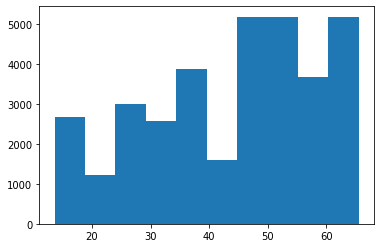

In [389]:
plt.hist(df_final2[df_final2['Precision']<df_final['Precision']]['Threashold'])